<a href="https://colab.research.google.com/github/Seunghoon-Yi/20-spring-ML/blob/master/Captcha_Recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M2608.001300 Machine Learning<br> Assignment #5 Final Projects (Pytorch)


Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them.

**For understanding of this work, please carefully look at given PPT file.**

Note: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimk

from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
from PIL import Image
import sys
sys.path.append('/content/drive/My Drive/final_projects')
import resnet
import torchvision.models as models

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Load datasets


In [ ]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
NONE = ['NONE'] # label for empty space
ALL_CHAR_SET = NUMBER + ALPHABET + NONE
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 7

print(ALL_CHAR_SET.index('NONE'))

def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

# modified dataset class
class Mydataset(Dataset):
    def __init__(self, img_path, label_path, is_train=True, transform=None):
        self.path = img_path
        self.label_path = label_path
        if is_train: 
            self.img = os.listdir(self.path)[:10000]
            self.labels = open(self.label_path, 'r').read().split('\n')[:-1][:10000]
        else: 
            self.img = os.listdir(self.path)[:1000]
            self.labels = open(self.label_path, 'r').read().split('\n')[:-1][:1000]
        
        self.transform = transform
        self.max_length = MAX_CAPTCHA
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(f'{self.path}/{self.img[idx]}')
        img = img.convert('L')
        label = self.labels[idx]
        label_oh = []
        # one-hot for each character
        for i in range(self.max_length):
            if i < len(label):
                label_oh += encode(label[i])
            else:
                #label_oh += [0]*ALL_CHAR_SET_LEN
                label_oh += encode('NONE')
            
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

#Train set transformation
transform_train = transforms.Compose([
    transforms.Resize([60,160]),
    transforms.Grayscale(),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0,shear = 10,scale = (0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

# Test set transformation
transform_test = transforms.Compose([
    transforms.Resize([60,160]),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])



36


In [ ]:
"""Loading DATA"""
# Change to your own data foler path!
gPath = '/content/drive/My Drive/final_projects/Data/'

train_ds = Mydataset(gPath+'Data/train/', gPath+'Data/train.txt', True, transform=transform_train)
test_ds = Mydataset(gPath+'Data/test/', gPath+'Data/test.txt',False, transform = transform_test)
train_dl = DataLoader(train_ds, batch_size=64, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=4)
print(len(train_ds))

10000


In [ ]:
"""To CUDA for local run"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#GPUID = '4' # define GPUID
#os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)


Problem 1: Design LSTM model for catcha image recognition. (10 points)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, cnn_dim, hidden_size, vocab_size, num_layers=1):
        super(LSTM, self).__init__()
        
        # define the properties
        self.cnn_dim = cnn_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=self.vocab_size, hidden_size=hidden_size)
        #self.lstm_cell_stack = nn.LSTMCell(input_size=self.hidden_size, hidden_size=hidden_size)
        #No improvement! 
    
        # output fully connected layer
        self.fc_in = nn.Linear(in_features=self.cnn_dim, out_features=self.vocab_size)
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.vocab_size)
    
        # activations
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, features, captions):

        batch_size = features.size(0)
        cnn_dim = features.size(1)
        #print("size", batch_size, cnn_dim)
        hidden_state = torch.zeros((batch_size, self.hidden_size)).cuda()
        cell_state = torch.zeros((batch_size, self.hidden_size)).cuda()
        # define the output tensor placeholder
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).cuda()
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
        #Features = torch.mean(torch.sum(feature, axis = 3), axis = 2)
        inputs = self.fc_in(features)
        for t in range(captions.size(1)):    # +1 is due to the skipped connection in captions at the very first step
            #64*512 > 64*37
            if captions.size(0) == 1:
                if t == 0:
                    hidden_state, cell_state = self.lstm_cell(inputs, (hidden_state, cell_state))
                ##### Inference stage ##### 
                else:
                    hidden_state, cell_state = self.lstm_cell((outputs[:, t-1, :]).view(1,37), (hidden_state, cell_state))
                out = self.fc_out(hidden_state)
                outputs[:, t-1, :] = out
            else:
                if t == 0:
                    hidden_state, cell_state = self.lstm_cell(inputs, (hidden_state, cell_state))
                ##### Teacher forcer stage #####
                else:
                    hidden_state, cell_state = self.lstm_cell((captions[:, t-1, :]).squeeze(), (hidden_state, cell_state))
                out = self.fc_out(hidden_state)
                outputs[:, t-1, :] = out
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################
        return outputs 




Problem 2: 

*   1.Connect CNN model to the desinged LSTM model.
*   2.Replace ResNet to your own CNN model from Assignment3.


          


In [ ]:

##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
"""ResNet"""
betternet = resnet.resnet34(pretrained=True)
betternet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(4,4), padding = (2,2),bias=True)
betternet.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)
betternet = betternet.to(device)
#betternet.cuda()
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

       
# LSTM
cnn_dim=512*3 #resnet34-512
hidden_size=10
vocab_size=37 #ALL_CHAR_SET_LEN
lstm = LSTM(cnn_dim=cnn_dim, hidden_size=hidden_size, vocab_size=vocab_size)
lstm = lstm.to(device)

# loss, optimizer
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
#label_oh = 
loss_func = nn.MultiLabelSoftMarginLoss()
cnn_optim = torch.optim.Adam(betternet.parameters(), lr=0.001)
rnn_optim = torch.optim.Adam(lstm.parameters(), lr = 0.15)
# test : torch.optim.SGD(lstm.parameters(), lr = 1, 0.9)
schedule = torch.optim.lr_scheduler.MultiStepLR(rnn_optim, \
            [3600,7200,15000], gamma = 0.1, last_epoch = -1)
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Problem3: Find hyper-parameters.


epoch: 1 step: 20 loss: 0.12744462490081787
0.15
epoch: 1 step: 40 loss: 0.09375468641519547
0.15
epoch: 1 step: 60 loss: 0.08963388949632645
0.15
epoch: 1 step: 80 loss: 0.08522268384695053
0.15
epoch: 1 step: 100 loss: 0.08653447777032852
0.15
epoch: 1 step: 120 loss: 0.08628926426172256
0.15
epoch: 1 step: 140 loss: 0.08504626899957657
0.15
epoch: 2 step: 20 loss: 0.08912256360054016
0.15
epoch: 2 step: 40 loss: 0.08982700854539871
0.15
epoch: 2 step: 60 loss: 0.08812201023101807
0.15
epoch: 2 step: 80 loss: 0.08461790531873703
0.15
epoch: 2 step: 100 loss: 0.08588551729917526
0.15
epoch: 2 step: 120 loss: 0.08597920835018158
0.15
epoch: 2 step: 140 loss: 0.08453495800495148
0.15
epoch: 3 step: 20 loss: 0.08884796500205994
0.15
epoch: 3 step: 40 loss: 0.08983410149812698
0.15
epoch: 3 step: 60 loss: 0.08811836689710617
0.15
epoch: 3 step: 80 loss: 0.084437295794487
0.15
epoch: 3 step: 100 loss: 0.08577241003513336
0.15
epoch: 3 step: 120 loss: 0.0861828550696373
0.15
epoch: 3 step: 

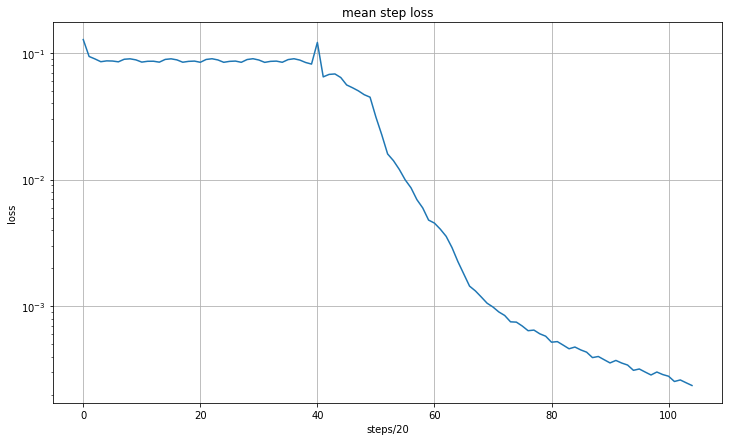

In [ ]:
"""TRAINING"""
print_interval = 20
max_epoch = 15
loss_mean = []
PATH = './chaptcha_net.pth'
#Net = LSTM()
for epoch in range(max_epoch):
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = Variable(img).cuda()
        label_oh = Variable(label_oh.float()).cuda()
        batch_size, _ = label_oh.shape
        pred, feature = betternet(img)
        outputs = lstm(feature.view(batch_size, -1),label_oh.view(batch_size, MAX_CAPTCHA, 37))
        #label_oh.view(batch_size, MAX_CAPTCHA, 37)
        loss = loss_func(outputs, label_oh.view(batch_size, MAX_CAPTCHA, 37))
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
        rnn_optim.zero_grad()
        loss.backward()
        rnn_optim.step()
        #print(rnn_optim.param_groups[0]['lr'])
        schedule.step()
##############################################################################
#                            END OF YOUR CODE                                #
##############################################################################
        if (step+1)%print_interval == 0:
            print('epoch:', epoch+1, 'step:', step+1, 'loss:', loss.item())
            loss_mean.append(loss.item())
            print(rnn_optim.param_groups[0]['lr'])

plt.rcParams["figure.figsize"] = (12,7)
plt.plot(range(len(loss_mean)), loss_mean)
plt.title("mean step loss")
plt.xlabel("steps/20");plt.ylabel("loss")
plt.yscale("log");plt.grid()

In [ ]:
print(loss_mean)
model_path = './fianl_net.pth'
optim_path = './fianl_opt.pth'
torch.save(lstm.state_dict(), model_path)
torch.save(rnn_optim.state_dict() , optim_path)

'''
# model state_dict confirm : 
print("Model's state_dict:")
for param_tensor in lstm.state_dict():
    print(param_tensor, "\t", lstm.state_dict()[param_tensor].size())

# opt state_dict confirm
print("Optimizer's state_dict:")
for var_name in rnn_optim.state_dict():
    print(var_name, "\t", rnn_optim.state_dict()[var_name])'''

[0.12744462490081787, 0.09375468641519547, 0.08963388949632645, 0.08522268384695053, 0.08653447777032852, 0.08628926426172256, 0.08504626899957657, 0.08912256360054016, 0.08982700854539871, 0.08812201023101807, 0.08461790531873703, 0.08588551729917526, 0.08597920835018158, 0.08453495800495148, 0.08884796500205994, 0.08983410149812698, 0.08811836689710617, 0.084437295794487, 0.08577241003513336, 0.0861828550696373, 0.08433892577886581, 0.08879276365041733, 0.08994565159082413, 0.08803896605968475, 0.08431325107812881, 0.08576549589633942, 0.08620705455541611, 0.08430923521518707, 0.0886746272444725, 0.08998338878154755, 0.08790984004735947, 0.08421215415000916, 0.08578143268823624, 0.08615675568580627, 0.08434408903121948, 0.08857016265392303, 0.0899496078491211, 0.08779896795749664, 0.08400995284318924, 0.08162623643875122, 0.12099166959524155, 0.0647016391158104, 0.06766508519649506, 0.06822062283754349, 0.0639193132519722, 0.05587024986743927, 0.05309736728668213, 0.05019071325659752

'\n# model state_dict confirm : \nprint("Model\'s state_dict:")\nfor param_tensor in lstm.state_dict():\n    print(param_tensor, "\t", lstm.state_dict()[param_tensor].size())\n\n# opt state_dict confirm\nprint("Optimizer\'s state_dict:")\nfor var_name in rnn_optim.state_dict():\n    print(var_name, "\t", rnn_optim.state_dict()[var_name])'

In [ ]:
###### Final test ######
final_ds = Mydataset(gPath+'Data/real_test/', gPath+'Data/real_test.txt',False, transform = transform_test)
final_dl = DataLoader(final_ds, batch_size=1, num_workers=4)

uw5aNONENONENONE gw5aNONENONENONE


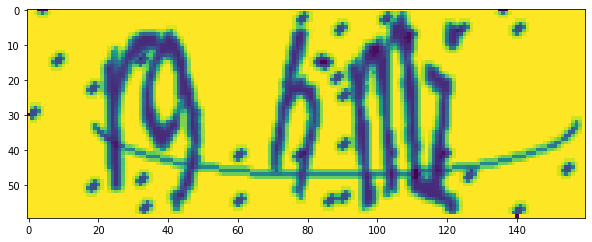

gw5a uw5aNONENONENONE
lzb lzbNONENONENONENONE
mbu mbuNONENONENONENONE
iywyfqg iywyfqNONE
q1von q1vonNONENONE
35ep 35epNONENONENONE
78i3 78i3NONENONENONE
yz yzNONENONENONENONENONE
mqmem7q mqmem7NONE
yhkq7 yhkq7NONENONE
3csnnl 3csnnlNONE
cr crNONENONENONENONENONE
nv62 nv62NONENONENONE
ic6nk ic6nkNONENONE
toapqt toapqtNONE
jc1c jc1cNONENONENONE
yyrt8m yyrt8mNONE
qd75n5j qd75n5NONE
393 393NONENONENONENONE
kez3 kez3NONENONENONE
f6 f6NONENONENONENONENONE
jxsta jxstaNONENONE
cz7829 cz7829NONE
mnntfr mnntfrNONE
dvffv dvffvNONENONE
694u97k 694u97NONE
lrvmt lrvmtNONENONE
c4zl c4zlNONENONENONE
gtvyfj gtvyfjNONE
kjncd kjncdNONENONE
jf82rgz jf82rgNONE
gg ggNONENONENONENONENONE
hzq hzqNONENONENONENONE
c2pdf c2pdfNONENONE
l4v3mmn l4v3mmNONE
fhyr fhyrNONENONENONE
b3ruq0 b3ruq0NONE
oxyfxa oxyfxaNONE
7zfc5tq 7zfc5tNONE
0vo43a NONEvo43aNONE
ktb ktbNONENONENONENONE
1sh NONEshNONENONENONENONE
es9046c es9046NONE
eorcybi eorcybNONE
so8 so8NONENONENONENONE
aqpytj aqpytjNONE
cshv cshvNONENONENONE
kxjfx kxjfxNO

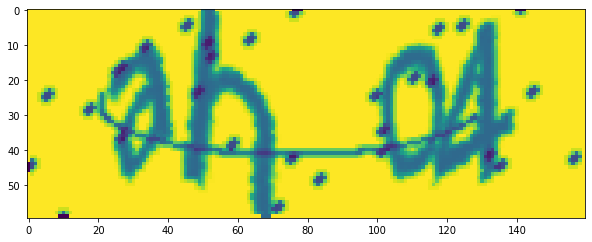

r9hmi r9hmiNONENONE
3j 3jNONENONENONENONENONE
o9 o9NONENONENONENONENONE
tja tjaNONENONENONENONE
1s7ae NONEs7aeNONENONE
zuu zuuNONENONENONENONE
ke keNONENONENONENONENONE
keiy3y keiy3yNONE
4utoqc 4utoqcNONE
41evw 41evwNONENONE
ur urNONENONENONENONENONE
wn wnNONENONENONENONENONE
t8 t8NONENONENONENONENONE
xftfis xftfisNONE
l4qwn l4qwnNONENONE
t05xjh t05xjhNONE
sorqd sorqdNONENONE
s75nq s75nqNONENONE
8j 8jNONENONENONENONENONE
a0z8495 a0z849NONE
ayoku3 ayoku3NONE
bxx bxxNONENONENONENONE
muyx0c muyx0cNONE
ngh nghNONENONENONENONE
cjw cjwNONENONENONENONE
9pa7z 9pa7zNONENONE
cfvdf cfvdfNONENONE
cnqc cnqcNONENONENONE
hmaz3wz hmaz3wNONE
6q 6qNONENONENONENONENONE
gq2rf gq2rfNONENONE
3tql 3tqlNONENONENONE
3w 3wNONENONENONENONENONE
d7u d7uNONENONENONENONE
z2mz0p z2mz0pNONE
ky9xv65 ky9xv6NONE
3e 3eNONENONENONENONENONE
k5c1e k5c1eNONENONE
p3499 p3499NONENONE
zuz zuzNONENONENONENONE
sw swNONENONENONENONENONE
8154ff 8154ffNONE
9yyr3 9yyr3NONENONE
8f 8fNONENONENONENONENONE
hovr hovrNONENONENONE
zo zoNONEN

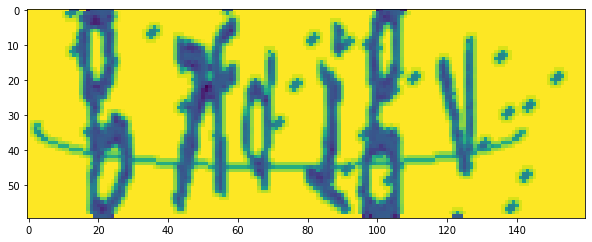

45 45NONENONENONENONENONE
v5t1z v5t1zNONENONE
rf4bi1 rf4bi1NONE
atep3 atep3NONENONE
g51yqa g51yqaNONE
h6yglo h6ygloNONE
acvw07o acvw07NONE
imresv8 imresvNONE
5162jj 5162jjNONE
kojr kojrNONENONENONE
rv87j9 rv87j9NONE
05 NONE5NONENONENONENONENONE
8r4awsm 8r4awsNONE
2qw 2qwNONENONENONENONE
n8h50kd n8h50kNONE
ofb1pt ofb1ptNONE
g3 g3NONENONENONENONENONE
iek6 iek6NONENONENONE
9kjx 9kjxNONENONENONE
ke keNONENONENONENONENONE
mpwy6 mpwy6NONENONE
8w4 8w4NONENONENONENONE
glamm glammNONENONE
5nhgqtm 5nhgqtNONE
lyg lygNONENONENONENONE
7nyo08a 7nyo08NONE
j73bz j73bzNONENONE
ta9w ta9wNONENONENONE
3j 3jNONENONENONENONENONE
is85w3 is85w3NONE
55wkj7d 55wkj7NONE
dmlc dmlcNONENONENONE
2bo0rc 2bo0rcNONE
ewgjni ewgjniNONE
lo3jch1 lo3jchNONE
2pk18r 2pk18rNONE
eg egNONENONENONENONENONE
h4 h4NONENONENONENONENONE
j1afd j1afdNONENONE
zqz82 zqz82NONENONE
jnaknz jnaknzNONE
sa saNONENONENONENONENONE
57cb315 57cb31NONE
hp hpNONENONENONENONENONE
n8i n8iNONENONENONENONE
5zg36 5zg36NONENONE
zq zqNONENONENONENONENONE
bt

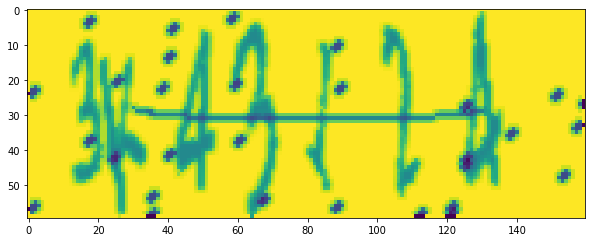

pt4m2pz pt4m2pNONE
jvdsw jvdswNONENONE
4x3zm 4x3zmNONENONE
f2 f2NONENONENONENONENONE
np npNONENONENONENONENONE
ie0r67 ie0r67NONE
z6dr9 z6dr9NONENONE
hzib hzibNONENONENONE
2h7lnfn 2h7lnfNONE
eu euNONENONENONENONENONE
c9wnqv c9wnqvNONE
b2rw b2rwNONENONENONE
ttr ttrNONENONENONENONE
s2 s2NONENONENONENONENONE
ycis0f ycis0fNONE
m865 m865NONENONENONE
278zj 278zjNONENONE
uui9e8 uui9e8NONE
q0 q0NONENONENONENONENONE
7s 7sNONENONENONENONENONE
9zdtf 9zdtfNONENONE
k2rfaq k2rfaqNONE
7nfss7 7nfss7NONE
7g 7gNONENONENONENONENONE
5t9d 5t9dNONENONENONE
94nh 94nhNONENONENONE
x5 x5NONENONENONENONENONE
v6sl6 v6sl6NONENONE
g0 g0NONENONENONENONENONE
7j8neu 7j8neuNONE
fae faeNONENONENONENONE
wu wuNONENONENONENONENONE
rz791f rz791fNONE
3gz8p 3gz8pNONENONE
43ogpu4 43ogpuNONE
3k43l24 3k43l2NONE
ah0i ah0iNONENONENONE
66 66NONENONENONENONENONE
etladfy etladfNONE
ofvluvn ofvluvNONE
zsbqof7 zsbqofNONE
ty8et ty8etNONENONE
tk2u tk2uNONENONENONE
b6s2w b6s2wNONENONE
uf1v uf1vNONENONENONE
1y NONEyNONENONENONENONENONE
g5 g

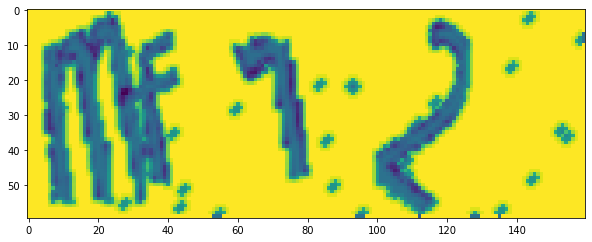

a9x a9xNONENONENONENONE
4ndp4k5 4ndp4kNONE
1ky3f5h NONEky3f5NONE
x0sbee6 x0sbeeNONE
r2fzo r2fzoNONENONE
8g5bcl 8g5bclNONE
4o 4oNONENONENONENONENONE
498nepm 498nepNONE
kasn kasnNONENONENONE
b9x6iw b9x6iwNONE
dye8t dye8tNONENONE
irb irbNONENONENONENONE
924x 924xNONENONENONE
s9 s9NONENONENONENONENONE
0z7uwas NONEz7uwaNONE
av avNONENONENONENONENONE
51ldq3 51ldq3NONE
wiqs wiqsNONENONENONE
nzu nzuNONENONENONENONE
cjlg cjlgNONENONENONE
uz uzNONENONENONENONENONE
owal0n7 owal0nNONE
xq xqNONENONENONENONENONE
sy syNONENONENONENONENONE
dai daiNONENONENONENONE
pe7fin pe7finNONE
8t1n7 8t1n7NONENONE
mfeqf6 mfeqf6NONE
do15 do15NONENONENONE
563 563NONENONENONENONE
5s7l 5s7lNONENONENONE
rr2l0v rr2l0vNONE
nnx7 nnx7NONENONENONE
rex0 rex0NONENONENONE
l5ven l5venNONENONE
91d2ftw 91d2ftNONE
g1 g1NONENONENONENONENONE
83pno 83pnoNONENONE
olcj8 olcj8NONENONE
rkk3tr rkk3trNONE
2b6v1y 2b6v1yNONE
t1e0pax t1e0paNONE
7odyi4l 7odyi4NONE
kb20o kb20oNONENONE
l1 l1NONENONENONENONENONE
nn7qw nn7qwNONENONE
eylwgy eylwgyNO

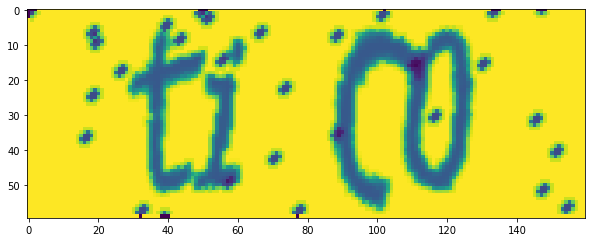

r0dq r0dqNONENONENONE
iii8 iii8NONENONENONE
wt wtNONENONENONENONENONE
gu1ouo gu1ouoNONE
zl zlNONENONENONENONENONE
ftwa ftwaNONENONENONE
b3 b3NONENONENONENONENONE
oxmstsp oxmstsNONE
0eie87 NONEeie87NONE
4zbg 4zbgNONENONENONE
xytex xytexNONENONE
twalcy twalcyNONE
f16 f16NONENONENONENONE
a4ip0t a4ip0tNONE
xxirims xxirimNONE
e92mbhs e92mbhNONE
64bn7 64bn7NONENONE
xc xcNONENONENONENONENONE
yeo yeoNONENONENONENONE
wf1 wf1NONENONENONENONE
rw5h rw5hNONENONENONE
zknu zknuNONENONENONE
f8d44 f8d44NONENONE
c5ovyt7 c5ovytNONE
6itd1 6itd1NONENONE
0bm NONEbmNONENONENONENONE
q2dyo q2dyoNONENONE
tuxr7 tuxr7NONENONE
g1ij0 g1ij0NONENONE
v8 v8NONENONENONENONENONE
tk0u tk0uNONENONENONE
fu7xpcb fu7xpcNONE
1i NONEiNONENONENONENONENONE
mjvglc mjvglcNONE
lvkh lvkhNONENONENONE
tf9fji tf9fjiNONE
o4lirt o4lirtNONE
3qf 3qfNONENONENONENONE
vfwjbvc vfwjbvNONE
nmircv nmircvNONE
r9u6 r9u6NONENONENONE
6tqr 6tqrNONENONENONE
16hj NONE6hjNONENONENONE
6zk5xq 6zk5xqNONE
93h 93hNONENONENONENONE
hoitgpv hoitgpNONE
vf vfNONENO

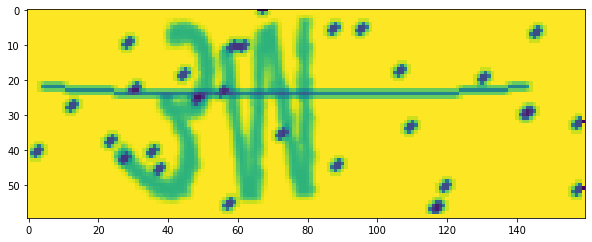

ex exNONENONENONENONENONE
0vzzt NONEvzztNONENONE
idnmejn idnmejNONE
qjc qjcNONENONENONENONE
rflud98 rflud9NONE
nj njNONENONENONENONENONE
gg ggNONENONENONENONENONE
10ws NONE0wsNONENONENONE
dk dkNONENONENONENONENONE
xq3 xq3NONENONENONENONE
dk873 dk873NONENONE
5s8oo4 5s8oo4NONE
jmscj0 jmscj0NONE
68nc 68ncNONENONENONE
3h 3hNONENONENONENONENONE
ia3u7t4 ia3u7tNONE
pff pffNONENONENONENONE
cp cpNONENONENONENONENONE
jyv4yxo jyv4yxNONE
l98 l98NONENONENONENONE
5ku3 5ku3NONENONENONE
x5z x5zNONENONENONENONE
4vzw 4vzwNONENONENONE
9o0 9o0NONENONENONENONE
mdas3wr mdas3wNONE
a6y a6yNONENONENONENONE
14ft8v NONE4ft8vNONE
xk33e0q xk33e0NONE
job7n job7nNONENONE
sfi sfiNONENONENONENONE
bv bvNONENONENONENONENONE
vm7 vm7NONENONENONENONE
z9yf4u z9yf4uNONE
6qwc 6qwcNONENONENONE
1w9j NONEw9jNONENONENONE
4dbgf2 4dbgf2NONE
4uhks 4uhksNONENONE
5gr 5grNONENONENONENONE
2gy5cub 2gy5cuNONE
35hga2 35hga2NONE
q3b6 q3b6NONENONENONE
mlc6zgk mlc6zgNONE
78f8w 78f8wNONENONE
gma4tp gma4tpNONE
rw0se5 rw0se5NONE
yuh14 yuh14NONEN

'END TEST'

In [ ]:
"""TEST"""
def get_char_count(arg1):
    c0 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    c5 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN*5:ALL_CHAR_SET_LEN*6])]
    c6 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN*6:ALL_CHAR_SET_LEN*7])]
    return c0, c1, c2,c3, c4, c5, c6 
 


char_correct = 0
word_correct = 0
total = 0

#temp_dl = DataLoader(train_ds, batch_size=1, num_workers=4)

betternet.eval()
lstm.eval()
plt.rcParams["figure.figsize"] = (10,6); it = 0

with torch.no_grad():
    for step, (img, label_oh, label) in enumerate(final_dl):
        char_count =0
        img = Variable(img).cuda()
        label_oh = Variable(label_oh.float()).cuda()
        pred, feature = betternet(img)

        label_len = label[0]
        batch_size, _ = label_oh.shape
        outputs = lstm(feature.view(batch_size, -1),pred.view(-1, MAX_CAPTCHA, 37))
        label_oh = label_oh.squeeze(0)
        
        c0,c1,c2,c3,c4,c5,c6 = get_char_count(outputs.view(1,MAX_CAPTCHA*ALL_CHAR_SET_LEN).squeeze()) 
        d0,d1,d2,d3,d4,d5,d6 = get_char_count(label_oh) 
         
        c = '%s%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5, c6)
        d = '%s%s%s%s%s%s%s' % (d0, d1, d2, d3, d4, d5, d6)
    
        char_count += (c0==d0)+(c1==d1)+(c2==d2)+(c3==d3)+(c4==d4)+(c5==d5)+(c6==d6)
        char_correct += char_count
        if it%150==0 :
            print(c,d)
        #plt.imshow(np.transpose((img.cpu()).numpy(), (1,2,0)))
            npimg = (img.cpu()).numpy()
            plt.imshow(npimg.squeeze())
            plt.show()

        if(bool(str(label[0]) in str(c))):
            word_correct+=1

        total += 1;it+=1
        print(label[0], c)
       
print(100/7*char_correct/total)
print(100*word_correct/total)
"""END TEST"""